# **Image Clustering**

# 1- Introduction
Clustering is the process of grouping (partitioning) objects into homogeneous groups (clusters).  
A cluster is a collection of objects (elements) that share common or very similar characteristics and are dissimilar from objects in other clusters.  
Clustering is the process of grouping (partitioning) objects into homogeneous groups (clusters).  
A cluster is a collection of objects (elements) that share common or very similar characteristics and are dissimilar from objects in other clusters.


# 2- Clustering Algorithms

There are numerous clustering algorithms that can be used in the field of Image Mining:

1. Centroid-based methods, such as K-means or K-medoids algorithms  
2. Hierarchical clustering methods  
3. Expectation-Maximization (EM) algorithm  
4. Fuzzy C-means clustering (FCM) algorithm  
   …


In [3]:
from google.colab import files
uploaded = files.upload()

Saving Image_clustering.rar to Image_clustering.rar


In [ ]:
!apt-get install unrar
!unrar x /content/DB_Clustering.rar /content/

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/DB_Clustering.rar

Creating    /content/2Classes                                         OK
Extracting  /content/2Classes/350000.jpg                                   0%  OK 
Extracting  /content/2Classes/350001.jpg                                   0%  OK 
Extracting  /content/2Classes/350002.jpg                                   0%  OK 
Extracting  /content/2Classes/350003.jpg                                   0%  OK 
Extracting  /content/2Classes/350004.jpg                                   0%  OK 
Extracting  /content/2Classes/350005.jpg                                   1%  OK 
Extracting  /content/2Classes/350006.jpg     

## 3.1- Clustering an Image Dataset into 2 Classes

The goal is to group the images from the "2Classes" image dataset into 2 classes. Visually, the images can be grouped into the classes "Maps" and "Nature."  
It is necessary to develop a model capable of correctly separating the images.


### 3.1.1- Feature Extraction

It is very convenient to use the features of an image instead of the intensity values of each pixel in a classification process.  

Thus, the first step in this process is feature extraction. In this workshop, 81 features will be used, which are:

- Statistical moments (mean and standard deviation) in the R, G, and B spaces ==> 6 features  
- Cumulative quantized histogram (8,2,2) in the HSV space ==> 32 features  
- Contrast, Correlation, Energy, and Homogeneity calculated from the GLCM (Gray Level Co-occurrence Matrix) for texture ==> 4 features  
- Histogram of the LBP (Local Binary Patterns) vector on the grayscale image for texture characterization ==> 32 features  
- Hu moments for shape characterization ==> 7 features  


In [1]:
featuresNumber=82
n_clusters=2
path2="/content/2Classes"

path4="/content/4Classes"

In [7]:
import cv2 as cv
import numpy as np
from math import ceil
# Code pour l'extraction des caracéristiques pour une image
def color_Moments(img):
  R = img[..., 0]
  G = img[..., 1]
  B = img[..., 2]
  colorFeatures = [np.mean(R),np.std(R),np.mean(G),np.std(G),np.mean(B),np.std(B)]
  colorFeatures /= np.mean(colorFeatures)
  return colorFeatures



In [ ]:
def hsvHistogramFeatures(image):
    [rows,cols,dd] = np.shape(image)
    # convertir l'image RGB en HSV.
    imageHSV = cv.cvtColor(image, cv.COLOR_RGB2HSV)
    # commenter ces 3 lignes pour un calcul sans méthodes
    hist = cv.calcHist([image], [0,1,2],None, [8, 2, 2],[0,180,0,256,0,256])
    hist=hist.flatten()
    hist/=np.sum(hist)
    return hist.reshape(-1)

In [ ]:
from skimage.feature import graycomatrix, graycoprops
def  textureFeatures(img):
    im = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    v = []
    glcm = graycomatrix(im, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    v.append(graycoprops(glcm, 'contrast')[0][0])
    v.append(graycoprops(glcm, 'correlation')[0][0])
    v.append(graycoprops(glcm, 'energy')[0][0])
    v.append(graycoprops(glcm, 'homogeneity')[0][0])
    v /= np.sum(v)
    return v

In [ ]:
def shapeFeatures(img):
    im = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    shapeFeat = cv.HuMoments(cv.moments(im)).flatten()
    shapeFeat /= np.mean(shapeFeat)
    return shapeFeat

In [ ]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern

def lbp_histogram(img):

    # Check if the image is in color (3D array) and convert to grayscale if necessary
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Parameters for LBP
    radius = 1
    n_points = 8 * radius

    # Compute LBP
    lbp = local_binary_pattern(img, n_points, radius, method='uniform')

    # Compute the histogram
    n_bins = 32
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)

    return hist


In [ ]:
def getFeatures(img,fsize = 81 ):
  features = np.zeros((fsize-1,1))
  features = np.concatenate((color_Moments(img), hsvHistogramFeatures(img)), axis=None)
  features = np.concatenate((features, textureFeatures(img)), axis=None)
  features = np.concatenate((features, shapeFeatures(img)), axis=None)
  features = np.concatenate((features, lbp_histogram(img)), axis=None)
  return features

In [ ]:
import os
def createFeatures(dataset_path):
  image_names=[]
  features = []
  dirs = os.listdir(dataset_path)
  dirs.sort()
  for image_name in dirs:
    image_path = dataset_path + "/" + image_name
    image = cv.imread(image_path)
    feature = getFeatures(image)
    features.append(feature)
    image_names.append(image_name)
  return features, image_names

In [ ]:
features, image_names= createFeatures(path2)

In [ ]:
print(np.array(image_names).shape)
print(np.array(features).shape)

(200,)
(200, 81)


### 3.1.2 Clustering with K-means

We will apply the K-means algorithm to the feature matrix.


In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import QuantileTransformer
n_clusters=2
kmeans = KMeans(n_clusters=n_clusters, algorithm="elkan", n_init=100, init='random')
img_features = QuantileTransformer(n_quantiles=10).fit_transform(features)
kmeans.fit(img_features)
print(kmeans.labels_)

NameError: name 'features' is not defined

In [ ]:
import matplotlib.pyplot as plt
print(image_names)

for i in range(190,200):
    img = path2 +'/' + image_names[i]
    image = cv.imread(img)
    plt.imshow(image, cmap='gray')
    plt.title(f" class: {kmeans.labels_[i]}")
    plt.axis('off')

    plt.show()


In [ ]:
import pandas as pd
def importToCsv(imgNm, pred_lbl, file_name):
  data = {'image_name': imgNm,
          'Class': pred_lbl
          }
  df = pd.DataFrame(data, columns= ['image_name', 'Class'])
  df.to_csv (file_name, index = False, header=True)

In [ ]:
importToCsv(image_names, kmeans.labels_,'cluster_Kmeans.csv')

### 3.1.2- K-Medoids

In this section, we will apply the unsupervised classification algorithm K-Medoids to the same feature matrix.


In [ ]:
# Il faut installer scikit-learn-extra pour pouvoir utiliser KMedoids
# !pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids
kmedoids = KMedoids(n_clusters=n_clusters, random_state=0)
kmedoids.fit(features)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.4 MB/s eta 0:00:00


KMedoids(n_clusters=2, random_state=0)

In [ ]:
importToCsv(image_names, kmedoids.labels_,'cluster_KMedoids.csv')

### 3.1.3- Hierarchical Clustering

We will use hierarchical clustering based on the Agglomerative Clustering algorithm using the same feature matrix.


In [ ]:
from sklearn.cluster import AgglomerativeClustering

hc_agg = AgglomerativeClustering(n_clusters=n_clusters)
hc_agg.fit(features)


AgglomerativeClustering()

In [ ]:
importToCsv(image_names, hc_agg.labels_,'cluster_Hierarchical.csv')
print(np.array(hc_agg.labels_).shape)

(200,)


### 3.1.4 FCM

For a fourth implementation of clustering, we will use the FCM (Fuzzy C-Means) algorithm.


In [ ]:
!pip install -U scikit-fuzzy
#import skfuzzy as fuzz
!pip install fuzzy-c-means
from fcmeans import FCM
fcm = FCM(n_clusters=n_clusters)
fcm.fit(np.array(features))
fcm_labels = fcm.predict(np.array(features))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 25.3 MB/s eta 0:00:00


In [ ]:
print()
importToCsv(image_names, fcm_labels,'cluster_FCM.csv')

## 3.2- Clustering into 4 Classes

In this section, we will perform clustering on the "4Classes" image dataset into 4 classes. We have chosen the K-Means clustering algorithm, and we will save the results in a *.csv file.


In [6]:
# Extraction des caractéristiques
features, image_names=createFeatures(path4)

# Clusetring
from sklearn.cluster import KMeans
from sklearn.preprocessing import QuantileTransformer
n_clusters=4
kmeans = KMeans(n_clusters=n_clusters, algorithm="elkan", n_init=100, init='random')
img_features = QuantileTransformer(n_quantiles=10).fit_transform(features)
kmeans.fit(img_features)
print(kmeans.labels_)

# Importation du résultat
importToCsv(image_names, kmeans.labels_,'cluster_Kmeans4C.csv')

NameError: name 'createFeatures' is not defined

## 3.3- Image Segmentation


### 3.3.1- Using Pixel Intensities

In this section, we will explore how to apply clustering algorithms for image segmentation. We will use the pixel intensities as clustering information.

First, we will segment the image in grayscale, and subsequently, we will segment the color image in the RGB space.


In [4]:
!unrar x /content/Image_clustering.rar /content/


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/Image_clustering.rar

Extracting  /content/test.bmp                                             10% 20% 25%  OK 
Extracting  /content/1.bmp                                                35% 45% 55% 60%  OK 
Extracting  /content/1_GT.bmp                                             62%  OK 
Extracting  /content/2.bmp                                                72% 82% 92% 98%  OK 
Extracting  /content/2_GT.bmp                                            100%  OK 
All OK


#### A- Segment the image in grayscale,

(337, 336)
(113232, 1)
(337, 336)


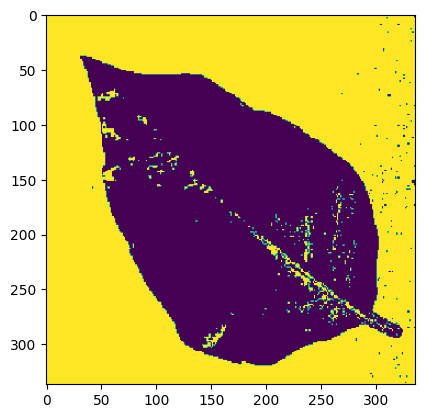

In [10]:
from sklearn.cluster import KMeans
image_path="/content/1.bmp"
image=cv.imread(image_path)
img= cv.cvtColor(image, cv.COLOR_RGB2GRAY)
print(img.shape)
# Code pour aplatir de l'image: 2D => 1D
img_reshape= img.reshape((-1, 1))
print(img_reshape.shape)

# Appliquer le K-means
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(img_reshape)

# Reconstruire le mask de segmentation 2D à partir des classes obtenues 1D
mask = kmeans.labels_.reshape(img.shape)
print(mask.shape)


#Afficher le mask de segmentation obtenu
import matplotlib.pyplot as plt
plt.imshow(mask)

In [13]:
print(kmeans.labels_)

[1 1 1 ... 1 1 1]


In [16]:
mask_path_1GT="/content/1_GT.bmp"
imageMask_1GT=cv.imread(mask_path_1GT, cv.IMREAD_GRAYSCALE).ravel()//255
imageMask_1GT = imageMask_1GT.reshape(-1,1)
y_1GT =np.concatenate(imageMask_1GT)

In [17]:
print(y_1GT)

[1 1 1 ... 1 1 1]


In [19]:

from sklearn.metrics import classification_report, confusion_matrix
y = kmeans.labels_
confusion_matrix(y_1GT, y)
rapport=classification_report(y_1GT, y)
# Afficher le rapport sous forme de tableau
print('Rapport de Classification : \n',rapport)
import sklearn.metrics as metrics
print("accuracy: ", metrics.accuracy_score(y_1GT, y))
print("precision: ", metrics.precision_score(y_1GT, y, average='macro'))
print("recall : ", metrics.recall_score(y_1GT, y, average='macro'))
print("f1 score: ", metrics.f1_score(y_1GT, y, average='macro'))

Rapport de Classification : 
               precision    recall  f1-score   support

           0       0.92      0.96      0.94     46465
           1       0.97      0.94      0.95     66767

    accuracy                           0.95    113232
   macro avg       0.94      0.95      0.95    113232
weighted avg       0.95      0.95      0.95    113232

accuracy:  0.9477532852903773
precision:  0.9438213204301743
recall :  0.9498789569733708
f1 score:  0.9464077174376759


#### B- Segment the color image in the RGB space


(337, 336, 3)
(113232, 3)
(337, 336)


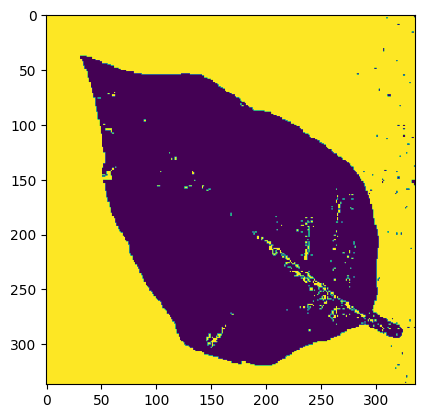

In [ ]:
image_path="/content/1.bmp"
image=cv.imread(image_path)
print(image.shape)
# Code pour aplatir de l'image: 3x2D => 3x1D
img_reshape= image.reshape((-1, 3))
print(img_reshape.shape)
# Appliquer le K-means
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(img_reshape)


# Reconstruire le mask de segmentation 2D à partir des classes obtenues 1D
mask= kmeans.labels_.reshape(image.shape[:2])
print(mask.shape)


#Afficher le mask de segmentation obtenu

import matplotlib.pyplot as plt
plt.imshow(mask)

### 3.3.2- Using Extracted Features for Each Pixel

Unlike the previous section, in this part, we will extract features for each pixel in addition to the intensity. This includes the difference with the maximum intensity, the difference with the minimum intensity, the difference with the average intensity, and the difference with the standard deviation of the intensities.

This will allow us to extract 5 features for each pixel.


(337, 336)
(113232, 1)
(113232, 5)
(113232, 5)
(113232, 5)
(337, 336)


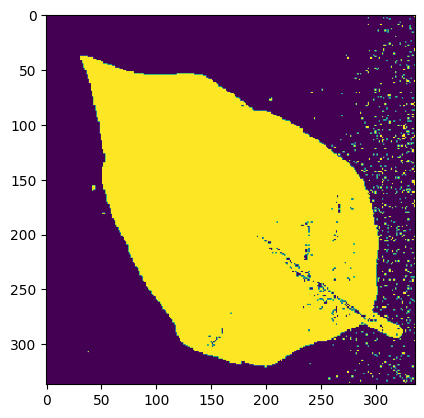

In [ ]:
from sklearn import preprocessing

# Extraction des caractéristiques
image_path="/content/1.bmp"
image=cv.imread(image_path)
img= cv.cvtColor(image, cv.COLOR_RGB2GRAY)
print(img.shape)

# Code pour aplatir de l'image: 2D => 1D
img_reshape=  img.reshape((-1, 1))
print(img_reshape.shape)

# Code pour extraires les caractéristiques de chaque pixel
clusteringFeat = np.zeros((img_reshape.shape[0], 5))

# Calculer les caractéristiques supplémentaires pour chaque pixel
intensity_max = np.max(img_reshape)  # Intensité maximale
intensity_min = np.min(img_reshape)  # Intensité minimale
intensity_mean = np.mean(img_reshape)  # Moyenne des intensités
intensity_std = np.std(img_reshape)  # Écart-type des intensités

clusteringFeat[:, 0] = img_reshape[:, 0]
clusteringFeat[:, 1] = intensity_max - img_reshape[:, 0]
clusteringFeat[:, 2] = img_reshape[:, 0] - intensity_min
clusteringFeat[:, 3] = img_reshape[:, 0] - intensity_mean
clusteringFeat[:, 4] = img_reshape[:, 0] - intensity_std
print(np.array(clusteringFeat).shape)

# Clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import QuantileTransformer
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, algorithm="elkan", n_init=100, init='random')
img_features = QuantileTransformer(n_quantiles=10).fit_transform(clusteringFeat)
kmeans.fit(img_features)
print(clusteringFeat.shape)
print(np.array(img_features).shape)
# Reconstruire le mask de segmentation 2D à partir des classes obtenues 1D
mask= kmeans.labels_.reshape(img.shape)
print(mask.shape)

#Afficher le mask de segmentation obtenu
import matplotlib.pyplot as plt
plt.imshow(mask)


## 3.4- Image Segmentation by Supervised Classification

In this section, we will develop a supervised classification model for image segmentation.

As input to the model, we will have an image and its segmentation mask. Thus, we will create a feature vector for each pixel using the respective intensities in R, G, B, H, S, and V. We will use the SVM (Support Vector Machine) classification algorithm.


### 3.4.1- Feature Extraction

In [38]:
# Charger l'image originale
image_path="/content/1.bmp"
image=cv.imread(image_path)

# Features dans l'espace RGB
R = image[:, :, 2].reshape(-1)
G = image[:, :, 1].reshape(-1)
B = image[:, :, 0].reshape(-1)


# Features dans l'espace HSV
imageHSV = cv.cvtColor(image, cv.COLOR_RGB2HSV)
H = imageHSV[:, :, 0].reshape(-1)
S = imageHSV[:, :, 1].reshape(-1)
V = imageHSV[:, :, 2].reshape(-1)

# Concatener les caractéristiques dans une variable X
X = np.column_stack((R, G, B, H, S, V))
print(X.shape)

(113232, 6)


### 3.4.2- Creating Labels

We will use the provided segmentation mask to create labels for each pixel.

In [39]:
import cv2 as cv
mask_path="/content/1_GT.bmp"
imageMask=cv.imread(mask_path, cv.IMREAD_GRAYSCALE)

imageMask =cv.imread(mask_path_1GT, cv.IMREAD_GRAYSCALE).ravel()//255
imageMask = imageMask.reshape(-1,1)
y = np.concatenate(imageMask)
# Concatener les etiquettes dans la variable Y
y = imageMask.reshape(-1)
print(y.shape)
print(np.array(y).shape)
print(np.array(imageMask).shape)

(113232,)
(113232,)
(113232, 1)


In [40]:
X.shape, y.shape

((113232, 6), (113232,))

### 3.4.3- Training and Evaluation

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
confusion_matrix(y_test, y_pred)
print(clf.score)
rapport=classification_report(y_test, y_pred)
# Afficher le rapport sous forme de tableau
print('Rapport de Classification : \n',rapport)
import sklearn.metrics as metrics
print("accuracy: ", metrics.accuracy_score(y_test, y_pred))
print("precision: ", metrics.precision_score(y_test, y_pred, average='macro'))
print("recall : ", metrics.recall_score(y_test, y_pred, average='macro'))
print("f1 score: ", metrics.f1_score(y_test, y_pred, average='macro'))

<bound method ClassifierMixin.score of SVC()>
Rapport de Classification : 
               precision    recall  f1-score   support

           0       0.91      0.86      0.88     17754
           1       0.88      0.92      0.90     19613

    accuracy                           0.89     37367
   macro avg       0.90      0.89      0.89     37367
weighted avg       0.89      0.89      0.89     37367

accuracy:  0.8936227152300158
precision:  0.8953282560308473
recall :  0.8919987286837985
f1 score:  0.8929879137273098


In [42]:
from sklearn import svm
clf = svm.SVC(C=1,kernel='rbf')
clf.fit(X, y)

SVC(C=1)

### 3.4.4- Segmenting a New Image

In [43]:
image_path="/content/2.bmp"
image=cv.imread(image_path)

# Features dans l'espace RGB
R = image[:, :, 2].reshape(-1)
G = image[:, :, 1].reshape(-1)
B = image[:, :, 0].reshape(-1)


# Features dans l'espace HSV
imageHSV = cv.cvtColor(image, cv.COLOR_RGB2HSV)
H = imageHSV[:, :, 0].reshape(-1)
S = imageHSV[:, :, 1].reshape(-1)
V = imageHSV[:, :, 2].reshape(-1)

# Créer le vecteur descripteur Xnew
Xnew = np.column_stack((R, G, B, H, S, V))
print(Xnew.shape)

(113232, 6)


In [44]:
y_new=clf.predict(Xnew)

(337, 336)


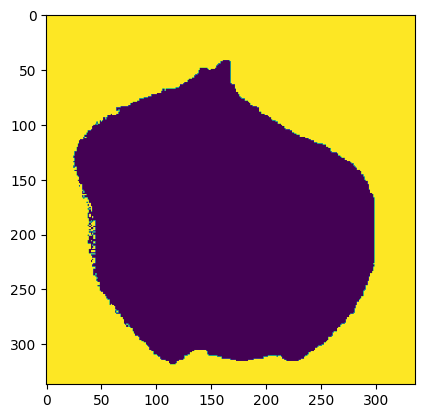

In [60]:
# Reconstruire le masque de segmentation
mask_new= y_new.reshape(image.shape[:2])
print(mask_new.shape)
plt.imshow(mask_new)

### 3.4.5- Evaluating the Model

To evaluate the model, we need to use the provided segmentation mask.

In [61]:
mask_path_1GT="/content/1_GT.bmp"
imageMask_1GT=cv.imread(mask_path_1GT, cv.IMREAD_GRAYSCALE).ravel()//255
imageMask_1GT = imageMask_1GT.reshape(-1,1)
y_1GT =np.concatenate(imageMask_1GT)

In [62]:
from sklearn.metrics import classification_report, confusion_matrix
y = kmeans.labels_
confusion_matrix(y_1GT, y)
rapport=classification_report(y_1GT, y)
# Afficher le rapport sous forme de tableau
print('Rapport de Classification pour Kmeans : \n',rapport)
import sklearn.metrics as metrics
print("accuracy: ", metrics.accuracy_score(y_1GT, y))
print("precision: ", metrics.precision_score(y_1GT, y, average='macro'))
print("recall : ", metrics.recall_score(y_1GT, y, average='macro'))
print("f1 score: ", metrics.f1_score(y_1GT, y, average='macro'))

print("\n\n")
mask_path_2GT="/content/2_GT.bmp"
imageMask_2GT=cv.imread(mask_path_2GT, cv.IMREAD_GRAYSCALE).ravel()//255
imageMask_2GT = imageMask_2GT.reshape(-1,1)
y_2GT =np.concatenate(imageMask_2GT)

y = y_new
confusion_matrix(y_2GT, y)
rapport=classification_report(y_2GT, y)
# Afficher le rapport sous forme de tableau
print('Rapport de Classification pour SVM : \n',rapport)
import sklearn.metrics as metrics
print("accuracy: ", metrics.accuracy_score(y_2GT, y))
print("precision: ", metrics.precision_score(y_2GT, y, average='macro'))
print("recall : ", metrics.recall_score(y_2GT, y, average='macro'))
print("f1 score: ", metrics.f1_score(y_2GT, y, average='macro'))

Rapport de Classification pour Kmeans : 
               precision    recall  f1-score   support

           0       0.92      0.96      0.94     46465
           1       0.97      0.94      0.95     66767

    accuracy                           0.95    113232
   macro avg       0.94      0.95      0.95    113232
weighted avg       0.95      0.95      0.95    113232

accuracy:  0.9477532852903773
precision:  0.9438213204301743
recall :  0.9498789569733708
f1 score:  0.9464077174376759



Rapport de Classification pour SVM : 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     52426
           1       1.00      0.98      0.99     60806

    accuracy                           0.98    113232
   macro avg       0.98      0.99      0.98    113232
weighted avg       0.98      0.98      0.98    113232

accuracy:  0.9845891620743252
precision:  0.9839691977238585
recall :  0.9853356359200625
f1 score:  0.9845280740851858
